# Big Data Analytics Project — Phase 2

This notebook extends Phase 1 by:
- Building a reusable **star schema** (dimensional model)
- Running analytics as reusable queries
- Testing performance / optimization ideas
- Building a simple playlist-continuation recommender and evaluating it


## 0) Setup & Parameters

We import the PySpark functions we use throughout the notebook, define small helper utilities (timing + query plan printing), and set Spark configuration that affects shuffle performance.


In [0]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import broadcast
from pyspark.sql.window import Window

import time
import math


### Helper utilities

We use a `timed()` helper to benchmark actions and a `print_plan()` helper to inspect Spark execution plans. This makes Phase 2 experiments easier to compare.


In [0]:
def timed(action_name, fn):
    start = time.time()
    out = fn()
    end = time.time()
    print(f"[TIMER] {action_name}: {end - start:.2f} sec")
    return out


def print_plan(title, df):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)
    df.explain(True)


### Spark settings + output base path

We set a shuffle partitions value that is reasonable for medium datasets. We also keep a base path for any file outputs (if needed).


In [0]:
spark.conf.set("spark.sql.shuffle.partitions", "200")

filestore_base = "dbfs:/FileStore/spotify_mpd_phase2"
print("filestore_base =", filestore_base)


filestore_base = dbfs:/FileStore/spotify_mpd_phase2


## 1) Load Phase 1 Outputs (Silver + Gold)

Phase 2 assumes Phase 1 created cleaned, structured tables. We load **Silver** tables as our main inputs. Gold tables are optional and used only when present.


In [0]:
try:
    playlists_silver_df = spark.table("silver_playlists")
    playlist_tracks_silver_df = spark.table("silver_playlist_tracks")
except Exception as exc:
    raise RuntimeError(
        "Could not find Phase 1 tables. Run Phase 1 first to create: "
        "silver_playlists and silver_playlist_tracks."
    ) from exc

print("silver_playlists rows:", playlists_silver_df.count())
print("silver_playlist_tracks rows:", playlist_tracks_silver_df.count())


silver_playlists rows: 1000000
silver_playlist_tracks rows: 66346428


### Preview the loaded data

We display a small sample from each table to confirm columns and types look correct.


In [0]:
display(playlists_silver_df.limit(5))


playlist_id,playlist_name,followers,num_tracks_declared,playlist_modified_ts,track_rows,unique_tracks,unique_artists,playlist_total_duration_ms,avg_track_duration_ms,modified_year,modified_month
967177,Stay With Me,1,74,2016-10-28T00:00:00.000Z,74,73,41,16483138,222745.1081081081,2016,10
354614,coolin,1,60,2014-10-05T00:00:00.000Z,60,58,44,14958081,249301.35,2014,10
863586,wake up,1,60,2015-06-28T00:00:00.000Z,60,60,37,12820435,213673.91666666666,2015,6
343108,nope,1,47,2017-05-16T00:00:00.000Z,47,47,27,9872675,210056.914893617,2017,5
989693,gym,1,36,2016-08-29T00:00:00.000Z,36,36,22,9377189,260477.47222222222,2016,8


In [0]:
display(playlist_tracks_silver_df.limit(5))


playlist_id,playlist_name,playlist_modified_at,playlist_followers,track_position,track_uri,track_name,artist_uri,artist_name,album_uri,album_name,duration_ms
996000,worship music,1428710400,1,11,spotify:track:43aEdyGKagb6NsVztpSgHq,Furious,spotify:artist:6jZbQXvNtDjnj18yoHMuvi,Jeremy Riddle,spotify:album:2XaIrC0s3gBJZntGhrFY25,Furious,237719
996001,Work,1470700800,1,27,spotify:track:63OmVzNwoMNn6hT7p5vwvX,Tom Ford,spotify:artist:3nFkdlSjzX9mRTtwJOzDYB,JAY Z,spotify:album:0anlRE2dYlRqEKL1gj1WPq,Magna Carta... Holy Grail,189013
996001,Work,1470700800,1,38,spotify:track:3ODXRUPL44f04cCacwiCLC,i,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,spotify:album:7ycBtnsMtyVbbwTfJwRjSP,To Pimp A Butterfly,336013
996001,Work,1470700800,1,169,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Usher,spotify:album:0vO0b1AvY49CPQyVisJLj0,Confessions,250373
996003,80's Music,1491350400,1,194,spotify:track:0jHkgTtTaqg5LNCiYDQPUB,Let's Get It On,spotify:artist:3koiLjNrgRTNbOwViDipeA,Marvin Gaye,spotify:album:6AmnVWOxXYucWxgidEgwhy,Let's Get It On,290960


### Load Gold tables

they can be reused for reporting or validation, but they are more important for dashboards.


In [0]:
gold_table_names = [
    "gold_artist_popularity",
    "gold_track_popularity",
    "gold_engagement_bins",
]

for table_name in gold_table_names:
    try:
        df = spark.table(table_name)
        print(f"{table_name} rows:", df.count())
    except Exception as exc:
        print(f"[WARN] {table_name} not found (OK). Reason: {exc}")


gold_artist_popularity rows: 287742
gold_track_popularity rows: 2262292
gold_engagement_bins rows: 4


### Quick schema check

Before building a star schema, we confirm the main keys and high-level structure.


In [0]:
print("silver_playlists columns:")
print(playlists_silver_df.columns)

print("\nsilver_playlist_tracks columns:")
print(playlist_tracks_silver_df.columns)


silver_playlists columns:
['playlist_id', 'playlist_name', 'followers', 'num_tracks_declared', 'playlist_modified_ts', 'track_rows', 'unique_tracks', 'unique_artists', 'playlist_total_duration_ms', 'avg_track_duration_ms', 'modified_year', 'modified_month']

silver_playlist_tracks columns:
['playlist_id', 'playlist_name', 'playlist_modified_at', 'playlist_followers', 'track_position', 'track_uri', 'track_name', 'artist_uri', 'artist_name', 'album_uri', 'album_name', 'duration_ms']


## 2) Build a Star Schema 

A star schema (dimensions + fact table) makes analytics faster and more reusable. We create:
- `dim_playlist` (playlist-level features)
- `dim_track` (track-level identity)
- `dim_artist` (artist-level identity)
- `fact_playlist_track` (playlist–track relationships)


### Safe column helper

Some columns may not exist in every version of the dataset. This helper returns the column if it exists; otherwise it returns a typed `NULL`. This keeps the pipeline robust without changing the intended logic.


In [0]:
def safe_col(df, col_name, cast_type=None, alias=None):
    """Return df[col_name] if it exists, else a NULL column with optional cast and alias."""
    if col_name in df.columns:
        col_expr = F.col(col_name)
    else:
        col_expr = F.lit(None)

    if cast_type is not None:
        col_expr = col_expr.cast(cast_type)

    if alias is not None:
        col_expr = col_expr.alias(alias)

    return col_expr


### Dimension table: Playlist

We keep playlist identifiers and a small set of features that are useful for analytics and modeling (followers, track counts, time fields).


In [0]:
dim_playlist_df = playlists_silver_df.select(
    "playlist_id",
    safe_col(playlists_silver_df, "playlist_name", alias="playlist_title"),
    safe_col(playlists_silver_df, "followers", cast_type="long", alias="followers"),
    safe_col(playlists_silver_df, "unique_tracks", cast_type="int", alias="unique_tracks"),
    safe_col(playlists_silver_df, "unique_artists", cast_type="int", alias="unique_artists"),
    safe_col(playlists_silver_df, "playlist_total_duration_ms", cast_type="long", alias="playlist_total_duration_ms"),
    safe_col(playlists_silver_df, "avg_track_duration_ms", cast_type="double", alias="avg_track_duration_ms"),
    safe_col(playlists_silver_df, "modified_year", cast_type="int", alias="modified_year"),
    safe_col(playlists_silver_df, "modified_month", cast_type="int", alias="modified_month"),
).dropDuplicates(["playlist_id"])


In [0]:
display(dim_playlist_df.limit(5))


playlist_id,playlist_title,followers,unique_tracks,unique_artists,playlist_total_duration_ms,avg_track_duration_ms,modified_year,modified_month
155264,rap favs,1,169,74,42247598,245625.56976744186,2017,2
419628,kuntry,1,109,57,26974602,245223.65454545454,2017,6
795743,Good,7,225,105,51876352,222645.28755364806,2017,10
453459,Senior Year,1,182,125,40284693,221344.46703296702,2017,6
342088,feel good,1,203,126,48227556,230753.85645933016,2017,10


**Key Insights**

- `dim_playlist` is the main place to store playlist features.
- `dropDuplicates` prevents later joins from inflating counts.


### Dimension table: Track

Tracks may appear many times across playlists. We store one row per `track_uri` and keep the most common observed name/artist to get a stable label.


In [0]:
dim_track_raw_df = playlist_tracks_silver_df.select(
    "track_uri",
    safe_col(playlist_tracks_silver_df, "track_name", alias="track_title"),
    safe_col(playlist_tracks_silver_df, "artist_name", alias="artist_name"),
).where(F.col("track_uri").isNotNull())

# Most common (track_title, artist_name) per track_uri
track_name_stats = (
    dim_track_raw_df
    .groupBy("track_uri", "track_title", "artist_name")
    .agg(F.count("*").alias("cnt"))
)

w_track = Window.partitionBy("track_uri").orderBy(F.desc("cnt"))

dim_track_df = (
    track_name_stats
    .withColumn("rn", F.row_number().over(w_track))
    .where(F.col("rn") == 1)
    .select("track_uri", "track_title", "artist_name")
)


In [0]:
display(dim_track_df.limit(5))


track_uri,track_title,artist_name
spotify:track:0009mEWM7HILVo4VZYtqwc,Movement,Slam
spotify:track:000DfZJww8KiixTKuk9usJ,Earthlings,Mike Love
spotify:track:000QFYFej3TzZq8HCTK36j,The Cold Swedish Winter,Jens Lekman
spotify:track:000q6cu9IRk2Ypfwb8671l,So in Love,Dick Haymes
spotify:track:001CyR8xqmmpVZFiTZJ5BC,She Knows How To Rock Me,Taj Mahal


**Key Insights**

- One `track_uri` can show up with inconsistent naming; the mode (most frequent) is a practical default.
- This table is small enough to broadcast in some optimizations.


### Dimension table: Artist

We store one row per artist name. (In MPD we do not always have stable artist IDs, so we use the name.)


In [0]:
dim_artist_df = (
    dim_track_df
    .select(F.col("artist_name").alias("artist_name"))
    .where(F.col("artist_name").isNotNull())
    .dropDuplicates(["artist_name"])
)


In [0]:
display(dim_artist_df.limit(5))


artist_name
Susanna
Workout Music Tv
Ziggy Marley
Eva Cassidy
Brian Tyler


**Key Insights**

- Artist names are not perfect IDs, but they allow useful high-level analytics.


### Fact table: Playlist–Track

The fact table captures the many-to-many relationship between playlists and tracks. This is the main table for frequency analysis and recommendation modeling.


In [0]:
fact_playlist_track_df = (
    playlist_tracks_silver_df.select(
        "playlist_id",
        "track_uri",
        safe_col(playlist_tracks_silver_df, "track_position", cast_type="int", alias="track_position"),
        safe_col(playlist_tracks_silver_df, "duration_ms", cast_type="long", alias="duration_ms"),
    )
    .where(F.col("playlist_id").isNotNull() & F.col("track_uri").isNotNull())
    .dropDuplicates(["playlist_id", "track_uri", "track_position"])
)


In [0]:
display(fact_playlist_track_df.limit(5))


playlist_id,track_uri,track_position,duration_ms
439647,spotify:track:0tUYkDafsrHR12unxfFQ5D,89,193784
133601,spotify:track:5OOkp4U9P9oL23maHFHL1h,147,246761
261569,spotify:track:7mitXLIMCflkhZiD34uEQI,2,262146
261786,spotify:track:6qC8Jj1XOxknPm8N7EbzKX,21,208666
76151,spotify:track:5HGibWoxnkYSkl6mHmAlOE,125,190186


**Key Insights**

- This table can become large, so we keep only necessary columns.
- Duplicate removal is important for correct counts.


### Row counts sanity check

Counts help confirm we did not accidentally lose data or multiply it through joins.


In [0]:
print("dim_playlist:", dim_playlist_df.count())
print("dim_track:", dim_track_df.count())
print("dim_artist:", dim_artist_df.count())
print("fact_playlist_track:", fact_playlist_track_df.count())


dim_playlist: 1000000
dim_track: 2262292
dim_artist: 287742
fact_playlist_track: 66346428


**Key Insights**

- `fact_playlist_track` should be close to the number of cleaned playlist-track records in Silver.


### Save the Star Schema as Delta Tables

We write the star schema as managed Delta tables so later steps can be rerun without rebuilding everything.


In [0]:
timed(
    "Write dim_playlist",
    lambda: (
        dim_playlist_df.write
        .mode("overwrite")
        .format("delta")
        .saveAsTable("dim_playlist")
    ),
)

timed(
    "Write dim_track",
    lambda: (
        dim_track_df.write
        .mode("overwrite")
        .format("delta")
        .saveAsTable("dim_track")
    ),
)

timed(
    "Write dim_artist",
    lambda: (
        dim_artist_df.write
        .mode("overwrite")
        .format("delta")
        .saveAsTable("dim_artist")
    ),
)

timed(
    "Write fact_playlist_track (partitioned)",
    lambda: (
        fact_playlist_track_df.write
        .mode("overwrite")
        .format("delta")
        .partitionBy("playlist_id")
        .saveAsTable("fact_playlist_track")
    ),
)

print("Star schema tables created: dim_playlist, dim_track, dim_artist, fact_playlist_track")


[TIMER] Write dim_playlist: 5.87 sec
[TIMER] Write dim_track: 7.18 sec
[TIMER] Write dim_artist: 5.59 sec
[TIMER] Write fact_playlist_track (partitioned): 1513.77 sec
Star schema tables created: dim_playlist, dim_track, dim_artist, fact_playlist_track


**Key Insights**

- Partitioning the fact table by `playlist_id` can help queries that filter by playlist.
- Delta tables make Phase 2 modular: analytics, optimization, and modeling can load the same tables.


## 3) Phase 2 Analytics: Turning Insights into Reusable Queries

We load the star schema tables and run analysis queries that can be reused as reporting building blocks.


In [0]:
spark.sql("SHOW TABLES").show(truncate=False)


+--------+----------------------+-----------+
|database|tableName             |isTemporary|
+--------+----------------------+-----------+
|default |bronze_raw_json       |false      |
|default |dim_artist            |false      |
|default |dim_playlist          |false      |
|default |dim_track             |false      |
|default |fact_playlist_track   |false      |
|default |gold_artist_popularity|false      |
|default |gold_engagement_bins  |false      |
|default |gold_track_popularity |false      |
|default |silver_playlist_tracks|false      |
|default |silver_playlists      |false      |
+--------+----------------------+-----------+



### Load star schema tables

We load the Delta tables we created to keep Phase 2 repeatable.


In [0]:
dim_playlist = spark.table("default.dim_playlist")
dim_track = spark.table("default.dim_track")
dim_artist = spark.table("default.dim_artist")
fact_pt = spark.table("default.fact_playlist_track")


### Query 1: Top playlists by followers

Followers can be used as a simple engagement proxy. We list the top playlists and their basic characteristics.


In [0]:
top_followed = (
    dim_playlist
    .orderBy(F.desc("followers"))
    .select("playlist_id", "playlist_title", "followers", "unique_tracks", "unique_artists")
    .limit(20)
)
display(top_followed)


playlist_id,playlist_title,followers,unique_tracks,unique_artists
248269,That's What I Like,71643,39,31
746359,Breaking Bad,53519,105,101
399472,One Tree Hill,45942,105,78
180831,My Little Pony,31539,82,25
720740,Q1,27830,81,72
928144,Jack's Playlist,23500,29,26
159077,Rock Hits,22102,56,54
7215,TOP POP,15842,52,41
768280,FARRUKO,15123,13,7
25495,Wiz Khalifa,14812,105,4


**Key Insights**

- High follower counts often correlate with higher diversity of tracks and artists.


### Query 2: Most frequent tracks across playlists

We count how many times each track appears in playlists. This reveals global popularity and is later used as a baseline recommender.


In [0]:
track_frequency = (
    fact_pt
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .orderBy(F.desc("appearances"))
)

top_tracks = (
    track_frequency
    .join(dim_track.select("track_uri", "track_title", "artist_name"), on="track_uri", how="left")
    .select("track_uri", "track_title", "artist_name", "appearances")
    .limit(20)
)

display(top_tracks)


track_uri,track_title,artist_name,appearances
spotify:track:0ZhGD08Tu5lbP0exD3QcT6,Crush On You,3LW,16
spotify:track:0cV4xwUA4ue2deqq4CZFko,I Don't Want This Night to End,Luke Bryan,6135
spotify:track:0x5bprvb1e5RQMhyjkmU0F,Mansion,Calvin Harris,169
spotify:track:0zO8ctW0UiuOefR87OeJOZ,Collard Greens,ScHoolboy Q,13016
spotify:track:1SKPmfSYaPsETbRHaiA18G,Somewhere Only We Know,Keane,7703
spotify:track:1ZwJALwnYbeHdEVCNVmniz,You,The 1975,1177
spotify:track:1zKk2FykUpgUPiUHulCiGv,Beautiful City (Bonus Track),Five For Fighting,11
spotify:track:2Y6XIn3zUdUYKLnKdtfNoA,Diamond in the Rough,Adam Jacobs,51
spotify:track:3cwDSDzTiWr5H5xMQhQ6Mx,Du hast,Rammstein,1741
spotify:track:3yhbwRROieRtlBlvPYZRiV,Calypso Blues,Calypso Rose,29


**Key Insights**

- The head of this distribution tends to be very concentrated (a few tracks appear in many playlists).
- Popularity can be a strong baseline, but it ignores personalization.


### Query 3: Long-tail distribution (tracks that appear rarely)

We check how many tracks appear only once, twice, etc. This shows how heavy the long-tail is.


In [0]:
tail_stats = (
    fact_pt
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .groupBy("appearances")
    .agg(F.count("*").alias("tracks_count"))
    .orderBy("appearances")
    .limit(30)
)

display(tail_stats)


appearances,tracks_count
1,1073419
2,323249
3,163849
4,102434
5,70696
6,52992
7,41559
8,33617
9,28044
10,23875


**Key Insights**

- A long-tail means many tracks have very little interaction data.
- This can make recommendation harder, especially for co-occurrence models.


### Query 4: Temporal activity (playlists per month)

We analyze how many playlists were modified each month and track a simple median-followers trend.


In [0]:
temporal_activity = (
    dim_playlist
    .groupBy("modified_year", "modified_month")
    .agg(
        F.count("*").alias("playlists_count"),
        F.expr("percentile_approx(followers, 0.5)").alias("median_followers"),
    )
    .orderBy("modified_year", "modified_month")
)

display(temporal_activity)


modified_year,modified_month,playlists_count,median_followers
2010,4,1,12
2010,6,2,1
2010,7,2,1
2010,9,1,1
2010,10,1,3
2010,11,2,1
2010,12,2,2
2011,1,3,1
2011,2,2,1
2011,3,3,1


**Key Insights**

- This gives a quick view of dataset coverage across time.
- Median followers is more robust than average for skewed follower distributions.


### Visual EDA

We visualize follower distribution using percentile-based bins. This avoids plots being dominated by extreme values.


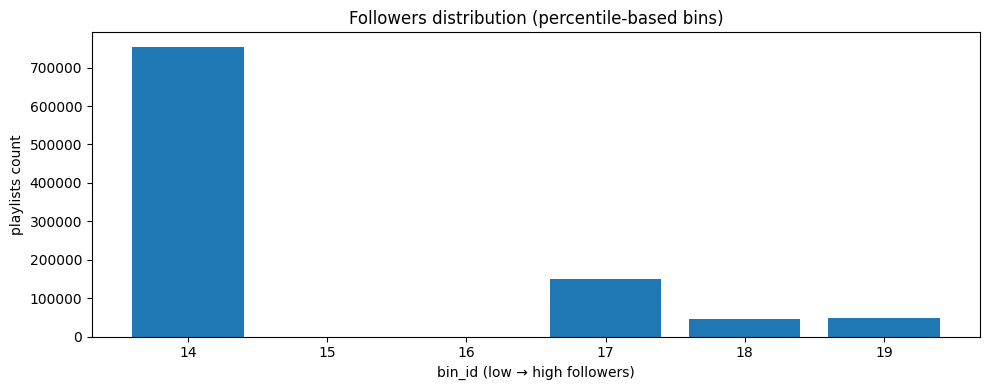

In [0]:
import matplotlib.pyplot as plt

# Prepare followers column
followers_df = (
    dim_playlist
    .select(F.col("followers").cast("double").alias("followers"))
    .where(F.col("followers").isNotNull())
)

# Percentile-based splits: 0%, 5%, ..., 100%
probs = [i / 20 for i in range(0, 21)]
split_points = followers_df.approxQuantile("followers", probs, 0.01)

# Build bins using the percentile cut points
binned = followers_df
for i in range(1, len(split_points)):
    low = split_points[i - 1]
    high = split_points[i]
    cond = (F.col("followers") >= F.lit(low)) & (F.col("followers") <= F.lit(high))
    binned = binned.withColumn(
        "bin_id",
        F.when(cond, F.lit(i - 1)).otherwise(F.col("bin_id")) if "bin_id" in binned.columns else F.when(cond, F.lit(i - 1))
    )

# Any remaining null bins (due to nulls / edge cases) go to the last bin
binned = binned.withColumn("bin_id", F.when(F.col("bin_id").isNull(), F.lit(len(split_points) - 2)).otherwise(F.col("bin_id")))

# Count playlists per bin
bin_counts = (
    binned.groupBy("bin_id")
    .count()
    .orderBy("bin_id")
    .toPandas()
)

plt.figure(figsize=(10, 4))
plt.bar(bin_counts["bin_id"], bin_counts["count"])
plt.title("Followers distribution (percentile-based bins)")
plt.xlabel("bin_id (low → high followers)")
plt.ylabel("playlists count")
plt.tight_layout()
plt.show()


**Key Insights**

- Percentile bins show the shape of the distribution without being overwhelmed by outliers.
- If most playlists fall in early bins, the follower distribution is highly skewed.


## 4) Performance & Optimization Experiments

We start from a baseline query, then try small changes to improve performance. The goal is not to "win" but to demonstrate optimization ideas:
- SQL temp views (readability + reuse)
- Broadcast join (reduce shuffle)
- Repartition strategy
- Skew handling (salting)
- Filter early (reduce input before aggregation)


### Baseline query function

We wrap the main query pattern into a function to keep experiments consistent.


In [0]:
def dashboard_query(dim_playlist_df, fact_df, dim_track_df, follower_threshold=1000):
    return (
        fact_df
        .join(dim_playlist_df.select("playlist_id", "followers"), on="playlist_id", how="inner")
        .where(F.col("followers") >= F.lit(follower_threshold))
        .groupBy("track_uri")
        .agg(F.count("*").alias("appearances"))
        .join(dim_track_df.select("track_uri", "track_title", "artist_name"), on="track_uri", how="left")
        .orderBy(F.desc("appearances"))
    )


### Baseline run

We benchmark the baseline and inspect its query plan.


In [0]:
q0 = dashboard_query(dim_playlist, fact_pt, dim_track, follower_threshold=1000)
print_plan("Baseline query plan (no optimizations)", q0)
timed("Baseline query action (collect top 20)", lambda: q0.limit(20).collect())



Baseline query plan (no optimizations)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Join UsingJoin(LeftOuter, [track_uri])
   :- 'Aggregate ['track_uri], ['track_uri, 'count(*) AS appearances#19748]
   :  +- 'Filter '`>=`('followers, 1000)
   :     +- 'Join UsingJoin(Inner, [playlist_id])
   :        :- 'UnresolvedRelation [default, fact_playlist_track], [], false
   :        +- 'Project ['playlist_id, 'followers]
   :           +- 'UnresolvedRelation [default, dim_playlist], [], false
   +- 'Project ['track_uri, 'track_title, 'artist_name]
      +- 'UnresolvedRelation [default, dim_track], [], false

== Analyzed Logical Plan ==
track_uri: string, appearances: bigint, track_title: string, artist_name: string
Sort [appearances#19748L DESC NULLS LAST], true
+- Project [track_uri#19754, appearances#19748L, track_title#19779, artist_name#19780]
   +- Join LeftOuter, (track_uri#19754 = track_uri#19778)
      :- Aggregate [track_uri#19754], [track_uri#19754, coun

[Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', appearances=11, track_title='Sign of the Times', artist_name='Harry Styles'),
 Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', appearances=11, track_title='All of Me', artist_name='John Legend'),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', appearances=9, track_title='Thinking Out Loud', artist_name='Ed Sheeran'),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', appearances=8, track_title='Drops of Jupiter', artist_name='Train'),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', appearances=8, track_title='Sweater Weather', artist_name='The Neighbourhood'),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', appearances=8, track_title='Lucky', artist_name='Jason Mraz'),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', appearances=8, track_title='Let It Go', artist_name='James Bay'),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', appearances=8, track_title='Iris', artist_name='The Goo Goo 

**Key Insights**

- The plan typically shows at least one large shuffle due to the aggregation and joins.


### Optimization 1: Temp views + SQL

SQL can make the query easier to read and share. The physical plan is usually similar, but it helps maintainability.


In [0]:
dim_playlist.createOrReplaceTempView("dim_playlist_v")
dim_track.createOrReplaceTempView("dim_track_v")
fact_pt.createOrReplaceTempView("fact_playlist_track_v")

q1 = spark.sql('''
SELECT
  f.track_uri,
  t.track_title,
  t.artist_name,
  COUNT(*) AS appearances
FROM fact_playlist_track_v f
JOIN dim_playlist_v p
  ON f.playlist_id = p.playlist_id
LEFT JOIN dim_track_v t
  ON f.track_uri = t.track_uri
WHERE p.followers >= 1000
GROUP BY f.track_uri, t.track_title, t.artist_name
ORDER BY appearances DESC
''')

print_plan("Optimization 1 plan (SQL temp views)", q1)
timed("Optimization 1 action (collect top 20)", lambda: q1.limit(20).collect())



Optimization 1 plan (SQL temp views)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Aggregate ['f.track_uri, 't.track_title, 't.artist_name], ['f.track_uri, 't.track_title, 't.artist_name, 'COUNT(1) AS appearances#20138]
   +- 'Filter ('p.followers >= 1000)
      +- 'Join LeftOuter, ('f.track_uri = 't.track_uri)
         :- 'Join Inner, ('f.playlist_id = 'p.playlist_id)
         :  :- 'SubqueryAlias f
         :  :  +- 'UnresolvedRelation [fact_playlist_track_v], [], false
         :  +- 'SubqueryAlias p
         :     +- 'UnresolvedRelation [dim_playlist_v], [], false
         +- 'SubqueryAlias t
            +- 'UnresolvedRelation [dim_track_v], [], false

== Analyzed Logical Plan ==
track_uri: string, track_title: string, artist_name: string, appearances: bigint
Sort [appearances#20138L DESC NULLS LAST], true
+- Aggregate [track_uri#20131, track_title#20123, artist_name#20124], [track_uri#20131, track_title#20123, artist_name#20124, count(1) AS appearances#

[Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', track_title='All of Me', artist_name='John Legend', appearances=11),
 Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', track_title='Sign of the Times', artist_name='Harry Styles', appearances=11),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', track_title='Thinking Out Loud', artist_name='Ed Sheeran', appearances=9),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', track_title='Lucky', artist_name='Jason Mraz', appearances=8),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', track_title='Drops of Jupiter', artist_name='Train', appearances=8),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', track_title='Let It Go', artist_name='James Bay', appearances=8),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', track_title='Iris', artist_name='The Goo Goo Dolls', appearances=8),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', track_title='Sweater Weather', artist_name='The Neighbourhood', appeara

### Optimization 2: Broadcast join for a small dimension table


If `dim_track` is small enough, broadcasting it can avoid a shuffle join.


In [0]:
q2 = (
    fact_pt
    .join(dim_playlist.select("playlist_id", "followers"), "playlist_id")
    .where(F.col("followers") >= 1000)
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .join(broadcast(dim_track.select("track_uri", "track_title", "artist_name")), "track_uri", "left")
    .orderBy(F.desc("appearances"))
)

print_plan("Optimization 2 plan (broadcast dim_track)", q2)
timed("Optimization 2 action (collect top 20)", lambda: q2.limit(20).collect())



Optimization 2 plan (broadcast dim_track)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Join UsingJoin(LeftOuter, [track_uri])
   :- 'Aggregate ['track_uri], ['track_uri, 'count(*) AS appearances#20603]
   :  +- 'Filter '`>=`('followers, 1000)
   :     +- 'Join UsingJoin(Inner, [playlist_id])
   :        :- 'UnresolvedRelation [default, fact_playlist_track], [], false
   :        +- 'Project ['playlist_id, 'followers]
   :           +- 'UnresolvedRelation [default, dim_playlist], [], false
   +- 'UnresolvedHint broadcast
      +- 'Project ['track_uri, 'track_title, 'artist_name]
         +- 'UnresolvedRelation [default, dim_track], [], false

== Analyzed Logical Plan ==
track_uri: string, appearances: bigint, track_title: string, artist_name: string
Sort [appearances#20603L DESC NULLS LAST], true
+- Project [track_uri#20621, appearances#20603L, track_title#20634, artist_name#20635]
   +- Join LeftOuter, (track_uri#20621 = track_uri#20633)
      :- Aggregate 

[Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', appearances=11, track_title='Sign of the Times', artist_name='Harry Styles'),
 Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', appearances=11, track_title='All of Me', artist_name='John Legend'),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', appearances=9, track_title='Thinking Out Loud', artist_name='Ed Sheeran'),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', appearances=8, track_title='Sweater Weather', artist_name='The Neighbourhood'),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', appearances=8, track_title='Drops of Jupiter', artist_name='Train'),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', appearances=8, track_title='Let It Go', artist_name='James Bay'),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', appearances=8, track_title='Iris', artist_name='The Goo Goo Dolls'),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', appearances=8, track_title='Lucky', artist_name='Jason

**Key Insights**

- Broadcast helps when one side is small; it can hurt if the broadcast table is large.


### Optimization 3: Repartition before aggregation

Repartitioning by the group key can sometimes reduce shuffle overhead (not always). This is an experiment.


In [0]:
fact_repartitioned = fact_pt.repartition(200, "track_uri")

q3 = (
    fact_repartitioned
    .join(dim_playlist.select("playlist_id", "followers"), "playlist_id")
    .where(F.col("followers") >= 1000)
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .join(broadcast(dim_track.select("track_uri", "track_title", "artist_name")), "track_uri", "left")
    .orderBy(F.desc("appearances"))
)

print_plan("Optimization 3 plan (repartition + broadcast)", q3)
timed("Optimization 3 action (collect top 20)", lambda: q3.limit(20).collect())



Optimization 3 plan (repartition + broadcast)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Join UsingJoin(LeftOuter, [track_uri])
   :- 'Aggregate ['track_uri], ['track_uri, 'count(*) AS appearances#20945]
   :  +- 'Filter '`>=`('followers, 1000)
   :     +- 'Join UsingJoin(Inner, [playlist_id])
   :        :- 'RepartitionByExpression ['track_uri], 200
   :        :  +- 'UnresolvedRelation [default, fact_playlist_track], [], false
   :        +- 'Project ['playlist_id, 'followers]
   :           +- 'UnresolvedRelation [default, dim_playlist], [], false
   +- 'UnresolvedHint broadcast
      +- 'Project ['track_uri, 'track_title, 'artist_name]
         +- 'UnresolvedRelation [default, dim_track], [], false

== Analyzed Logical Plan ==
track_uri: string, appearances: bigint, track_title: string, artist_name: string
Sort [appearances#20945L DESC NULLS LAST], true
+- Project [track_uri#20963, appearances#20945L, track_title#20976, artist_name#20977]
   +- Join L

[Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', appearances=11, track_title='Sign of the Times', artist_name='Harry Styles'),
 Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', appearances=11, track_title='All of Me', artist_name='John Legend'),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', appearances=9, track_title='Thinking Out Loud', artist_name='Ed Sheeran'),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', appearances=8, track_title='Sweater Weather', artist_name='The Neighbourhood'),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', appearances=8, track_title='Let It Go', artist_name='James Bay'),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', appearances=8, track_title='Drops of Jupiter', artist_name='Train'),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', appearances=8, track_title='Iris', artist_name='The Goo Goo Dolls'),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', appearances=8, track_title='Lucky', artist_name='Jason

### Optimization 4: Skew handling (Salting)

Some tracks appear extremely often and can create skew (one reducer gets too much work). We identify heavy keys and add a salt value for a two-stage aggregation.


In [0]:
# Identify heavy tracks (top 0.1% by appearances) as skewed keys
track_counts = fact_pt.groupBy("track_uri").count()
threshold = track_counts.approxQuantile("count", [0.999], 0.01)[0]

heavy_tracks = track_counts.where(F.col("count") >= F.lit(threshold)).select("track_uri")
print("heavy_tracks:", heavy_tracks.count())

SALT_N = 10

fact_salted = (
    fact_pt
    .join(heavy_tracks.withColumn("is_heavy", F.lit(1)), on="track_uri", how="left")
    .withColumn(
        "salt",
        F.when(F.col("is_heavy") == 1, (F.rand(seed=42) * SALT_N).cast("int")).otherwise(F.lit(0)),
    )
)

# Stage 1 aggregation on (track_uri, salt)
stage1 = (
    fact_salted
    .join(dim_playlist.select("playlist_id", "followers"), "playlist_id")
    .where(F.col("followers") >= 1000)
    .groupBy("track_uri", "salt")
    .agg(F.count("*").alias("partial_cnt"))
)

# Stage 2 aggregation removes salt
q4 = (
    stage1
    .groupBy("track_uri")
    .agg(F.sum("partial_cnt").alias("appearances"))
    .join(broadcast(dim_track.select("track_uri", "track_title", "artist_name")), "track_uri", "left")
    .orderBy(F.desc("appearances"))
)

print_plan("Optimization 4 plan (skew handling via salting)", q4)
timed("Optimization 4 action (collect top 20)", lambda: q4.limit(20).collect())


heavy_tracks: 1

Optimization 4 plan (skew handling via salting)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Join UsingJoin(LeftOuter, [track_uri])
   :- 'Aggregate ['track_uri], ['track_uri, 'sum('partial_cnt) AS appearances#21542]
   :  +- 'Aggregate ['track_uri, 'salt], ['track_uri, 'salt, 'count(*) AS partial_cnt#21520]
   :     +- 'Filter '`>=`('followers, 1000)
   :        +- 'Join UsingJoin(Inner, [playlist_id])
   :           :- Project [track_uri#21494, playlist_id#21493L, track_position#21495, duration_ms#21496L, is_heavy#21488, CASE WHEN (is_heavy#21488 = 1) THEN cast((rand(42) * cast(10 as double)) as int) ELSE 0 END AS salt#21499]
   :           :  +- Project [track_uri#21494, playlist_id#21493L, track_position#21495, duration_ms#21496L, is_heavy#21488]
   :           :     +- Join LeftOuter, (track_uri#21494 = track_uri#21482)
   :           :        :- SubqueryAlias workspace.default.fact_playlist_track
   :           :        :  +- Relation 

[Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', appearances=11, track_title='Sign of the Times', artist_name='Harry Styles'),
 Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', appearances=11, track_title='All of Me', artist_name='John Legend'),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', appearances=9, track_title='Thinking Out Loud', artist_name='Ed Sheeran'),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', appearances=8, track_title='Iris', artist_name='The Goo Goo Dolls'),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', appearances=8, track_title='Let It Go', artist_name='James Bay'),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', appearances=8, track_title='Sweater Weather', artist_name='The Neighbourhood'),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', appearances=8, track_title='Lucky', artist_name='Jason Mraz'),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', appearances=8, track_title='Drops of Jupiter', artist_name='

**Key Insights**

- Salting spreads heavy keys across partitions in the first stage.
- It adds work (two-stage aggregation), so it is useful mainly when skew is severe.


### Optimization 5: Filter early

Filtering playlists early reduces the fact table input size before the groupBy.


In [0]:
high_follow_playlists = dim_playlist.select("playlist_id").where(F.col("followers") >= 1000)

q5 = (
    fact_pt
    .join(high_follow_playlists, "playlist_id")
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .join(broadcast(dim_track.select("track_uri", "track_title", "artist_name")), "track_uri", "left")
    .orderBy(F.desc("appearances"))
)

print_plan("Optimization 5 plan (filter early)", q5)
timed("Optimization 5 action (collect top 20)", lambda: q5.limit(20).collect())



Optimization 5 plan (filter early)
== Parsed Logical Plan ==
'Sort ['appearances DESC NULLS LAST], true
+- 'Join UsingJoin(LeftOuter, [track_uri])
   :- 'Aggregate ['track_uri], ['track_uri, 'count(*) AS appearances#21877]
   :  +- 'Join UsingJoin(Inner, [playlist_id])
   :     :- 'UnresolvedRelation [default, fact_playlist_track], [], false
   :     +- 'Filter '`>=`('followers, 1000)
   :        +- 'Project ['playlist_id]
   :           +- 'UnresolvedRelation [default, dim_playlist], [], false
   +- 'UnresolvedHint broadcast
      +- 'Project ['track_uri, 'track_title, 'artist_name]
         +- 'UnresolvedRelation [default, dim_track], [], false

== Analyzed Logical Plan ==
track_uri: string, appearances: bigint, track_title: string, artist_name: string
Sort [appearances#21877L DESC NULLS LAST], true
+- Project [track_uri#21895, appearances#21877L, track_title#21908, artist_name#21909]
   +- Join LeftOuter, (track_uri#21895 = track_uri#21907)
      :- Aggregate [track_uri#21895], [tr

[Row(track_uri='spotify:track:5Ohxk2dO5COHF1krpoPigN', appearances=11, track_title='Sign of the Times', artist_name='Harry Styles'),
 Row(track_uri='spotify:track:3uhBIQ7tv8j1FME8cFGEfG', appearances=11, track_title='All of Me', artist_name='John Legend'),
 Row(track_uri='spotify:track:1Slwb6dOYkBlWal1PGtnNg', appearances=9, track_title='Thinking Out Loud', artist_name='Ed Sheeran'),
 Row(track_uri='spotify:track:6Qyc6fS4DsZjB2mRW9DsQs', appearances=8, track_title='Iris', artist_name='The Goo Goo Dolls'),
 Row(track_uri='spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA', appearances=8, track_title='Drops of Jupiter', artist_name='Train'),
 Row(track_uri='spotify:track:2qLMf6TuEC3ruGJg4SMMN6', appearances=8, track_title='Lucky', artist_name='Jason Mraz'),
 Row(track_uri='spotify:track:13HVjjWUZFaWilh2QUJKsP', appearances=8, track_title='Let It Go', artist_name='James Bay'),
 Row(track_uri='spotify:track:2QjOHCTQ1Jl3zawyYOpxh6', appearances=8, track_title='Sweater Weather', artist_name='The Neighbou

**Key Insights**

- This is often a simple win: reduce the dataset before the expensive aggregation.


## 5) Simple Playlist-Continuation Recommender (Baseline + One Improved Model)

Goal: recommend tracks to extend a playlist.

We implement two models:
- **Model A (Baseline):** global popularity
- **Model B (Improved):** item–item co-occurrence 

We create a simple evaluation split by holding out the last *K* tracks of each playlist.


### Prepare ordered track lists per playlist

We build an ordered list of tracks per playlist using `track_position` when available. If position is missing, we create a stable pseudo-order.


In [0]:
# Keep only fields needed for ordering
pt_order = fact_pt.select(
    "playlist_id",
    "track_uri",
    safe_col(fact_pt, "track_position", cast_type="int", alias="track_position"),
)

# If track_position is missing, create a stable pseudo-order
if "track_position" not in fact_pt.columns:
    w_rand = Window.partitionBy("playlist_id").orderBy(F.rand(seed=42))
    pt_order = pt_order.withColumn("track_position", F.row_number().over(w_rand))

playlist_sizes = pt_order.groupBy("playlist_id").agg(F.count("*").alias("n_tracks"))


### Filter playlists with enough tracks

To evaluate, each playlist should have enough tracks to create a train/test split.


In [0]:
HOLDOUT_K = 5

eligible_playlists = playlist_sizes.where(F.col("n_tracks") > (HOLDOUT_K + 5)).select("playlist_id")

pt_order_f = (
    pt_order
    .join(eligible_playlists, "playlist_id", "inner")
    .where(F.col("track_uri").isNotNull())
)

tracks_ordered = (
    pt_order_f
    .orderBy("playlist_id", "track_position")
    .groupBy("playlist_id")
    .agg(F.collect_list("track_uri").alias("tracks"))
)


### Train/test split 

We hold out the last `HOLDOUT_K` tracks for evaluation. The remaining tracks are the input (train).


In [0]:
data_split = (
    tracks_ordered
    .withColumn("n", F.size("tracks"))
    .withColumn("train_tracks", F.expr(f"slice(tracks, 1, n-{HOLDOUT_K})"))
    .withColumn("test_tracks", F.expr(f"slice(tracks, n-{HOLDOUT_K}+1, {HOLDOUT_K})"))
    .select("playlist_id", "train_tracks", "test_tracks")
)

display(data_split.limit(5))
print("Evaluation playlists:", data_split.count())


playlist_id train_tracks test_tracks 244635 List(spotify:track:6Q1NPLtp9IzcXmCutp3Qmo, spotify:track:0uMUvbkTdjBNZ5UuHZ5PIj, spotify:track:24BSTATmWEmrPOgEM17bfN, spotify:track:3KiEydhjn7yf58h9jBD5Sa, spotify:track:1jQsKN68yE94tMYml0wHMd, spotify:track:20dP2DaMHIAmwWAbp7peSr, spotify:track:5v7kaZNsnyByrSJOfO8gKq, spotify:track:5yPpCPB5D4RLFpCvaK3n0f, spotify:track:4k2l5T9ulYdnlQzlmzSqUI, spotify:track:0GR7iJLhj80KD5LkA14ZRn, spotify:track:5mPSyjLatqB00IkPqRlbTE, spotify:track:0B8QzDH7YWih85V5SEMnyJ, spotify:track:31G9RaSaDOI2NWcpnIp734, spotify:track:6fujklziTHa8uoM5OQSfIo, spotify:track:5BtN3kFKoISSWFpXWz7O4L, spotify:track:4IWGnyOHDrVZEtPWfs4s7q, spotify:track:7KXjTSCq5nL1LoYtL7XAwS, spotify:track:03tqyYWC9Um2ZqU0ZN849H, spotify:track:1zayuwd1YLZsYDArkruHdL, spotify:track:2ikkgfIIM9kGKZCXzXnTpj, spotify:track:0Y0TOsE1q11qgbi7c5WZsG, spotify:track:7GX5flRQZVHRAGd6B4TmDO, spotify:track:57pOLYHz6mt5aMkOXa2Gis, spotify:track:2EEeOnHehOozLq4aS0n6SL, spotify:track:4iQLJCvthLGQDXFYkfAXbG, spotify:track:4Pwjz3DfvfQWV0rO2V8jyh, spotify:track:7eaKWfov7b2Qa2n6HTesL3, spotify:track:79reBHqpRoWXaQbjBBY3UC, spotify:track:0z5ZPs57J2KERwM1tBM2GF, spotify:track:5oyUurs28XRagLa8lgm6V3, spotify:track:7odIekt1GqLVEAAWdnd9mJ, spotify:track:5Uj2at1EGAaWCrLyEUuXBp, spotify:track:7jVKBOFb76u3HzaJ2vaKPW, spotify:track:4bBU3OPgbPmTRPJTS3kCUM, spotify:track:3XQY8kDjI8LARMIC9xkxQk, spotify:track:4uQ7wYsuL0DryknoDc11Hk, spotify:track:3pndPhlQWjuSoXhcIIdBjv, spotify:track:3rbNV2GI8Vtd8byhUtXZID, spotify:track:27GmP9AWRs744SzKcpJsTZ, spotify:track:42GcjriRK6srwHkfbkBqVl, spotify:track:03IxJiB8ZOH9hEQZF5mCNY, spotify:track:1yxgsra98r3qAtxqiGZPiX, spotify:track:283oECb9VZOCmdcKdL0Juv, spotify:track:5XJJdNPkwmbUwE79gv0NxK, spotify:track:6vqfBeixHaipO8JodsohEn, spotify:track:0UQSejhENSARRjmb9nq1cl, spotify:track:4ljFgxQtSqphJtLnqGt0UG, spotify:track:4ZfB37omywo04Pm1Uw0EEQ, spotify:track:1CkngqW8jCUZ7LAk0UhWk7, spotify:track:2okC0OWtgS86P2LC18IzHy, spotify:track:4pdgV8qr9Oytcv6thCdiIZ, spotify:track:4ImL3v98u2BLkwnyQDjfRm, spotify:track:7BKLCZ1jbUBVqRi2FVlTVw, spotify:track:4dVJyyeCPEONr44NIrXvie, spotify:track:6j0teRL3WdExzqmy334sh5, spotify:track:2ANLarE8yHVsLWW21nj79M, spotify:track:7EoSDrwBPUBeBEORrpvgko, spotify:track:69M9QCMsCQ5MLsw7BBW0rL, spotify:track:5QxqypupYWHrY8IkGCSObQ, spotify:track:3LHWJ7C6P8fGzpdoiuoI3A, spotify:track:4BP0An7SXctTY4kF41JxIQ, spotify:track:6ltPEsP4edATzvinHOzvk2, spotify:track:1cMMa7Y8G1hb8JK6jD8iL9, spotify:track:2NRUU0gP1d8Yif8CpsCW8l, spotify:track:2FtODdMaymGKIEwO7zOGM1, spotify:track:1xznGGDReH1oQq0xzbwXa3, spotify:track:7Ezwtgfw7khBrpvaNPtMoT, spotify:track:1wHZx0LgzFHyeIZkUydNXq, spotify:track:5I6YA7oHtraxwWQzzCugDt, spotify:track:3clX2NMmjaAHmBjeTSa9vV, spotify:track:1e1JKLEDKP7hEQzJfNAgPl, spotify:track:55Q46o5adtSobImSKrrlqW, spotify:track:6fAyRZ0GHuuvSOEIOwi58N, spotify:track:6JjEVlMkfHWMeYavkEYzNO, spotify:track:39hnH8WdPmNT3Q3yzwC9Rg, spotify:track:1yYzuNd0KRyHVJ3NH8apBt, spotify:track:0VgkVdmE4gld66l8iyGjgx, spotify:track:6p8NuHm8uCGnn2Dtbtf7zE, spotify:track:0pSBuHjILhNEo55xK1zrRt, spotify:track:1OAh8uOEOvTDqkKFsKksCi, spotify:track:63OmVzNwoMNn6hT7p5vwvX, spotify:track:3xPVwMlzgyd8ooUDKzeKqj, spotify:track:1pF3VcWYHeuVPflRwGBaWV, spotify:track:2yJ9GVCLMmzBBfQAnfzlwr, spotify:track:0gqfvyewE2Sh8TwKBFajCF, spotify:track:1X4PsdScsMExfuNFPLNcTT, spotify:track:53iTGmEL4uwHlqUvuKcrQe, spotify:track:6BdgtqiV3oXNqBikezwdvC, spotify:track:6QvxTX9zvo4u7XhP9vOP3n, spotify:track:75L0qdzRnhwV62UXoNq3pE, spotify:track:6ScJMrlpiLfZUGtWp4QIVt, spotify:track:1uDjaezEbalGyGnuH80zDK, spotify:track:5DLTuH4A5VZB2HKpqHQR6t, spotify:track:1CetnEx843dN0s9fT0CMhc, spotify:track:4X5f3vT8MRuXF68pfjNte5, spotify:track:439TlnnznSiBbQbgXiBqAd, spotify:track:2w9Qq5cflc8Z6BraiDCyes, spotify:track:1fLdeDTrJWNkwOeFyAVLvF, spotify:track:788NX6uCNEVuZW8x5BkQqM, spotify:track:53gcDgFyqqpvCzXWrnFZpH, spotify:track:3Qu5bTS5AvgS0TpeGhQyfc, spotify:track:29gsi1zZrZxdStACmTQB0Z, spotify:track:5NFYuqu8V6QXc6mzcLImd6, spotify:track:433P7tDcIAi6NLnf4Sh6tI,

Evaluation playlists: 953325


**Key Insights**

- This split simulates playlist continuation: predict the later tracks using earlier tracks.
- It is simple and reproducible, but it assumes order is meaningful.


### Model A: Global popularity baseline

We recommend the most frequent tracks overall, excluding tracks already present in the playlist.


In [0]:
TOPN_POOL = 500
K = 50

global_popularity = (
    fact_pt
    .groupBy("track_uri")
    .agg(F.count("*").alias("appearances"))
    .orderBy(F.desc("appearances"))
    .limit(TOPN_POOL)
    .select("track_uri")
)

display(global_popularity.limit(10))


track_uri
spotify:track:7KXjTSCq5nL1LoYtL7XAwS
spotify:track:1xznGGDReH1oQq0xzbwXa3
spotify:track:7yyRTcZmCiyzzJlNzGC9Ol
spotify:track:7BKLCZ1jbUBVqRi2FVlTVw
spotify:track:3a1lNhkSLSkpJE4MSHpDu9
spotify:track:5hTpBe8h35rJ67eAWHQsJx
spotify:track:2EEeOnHehOozLq4aS0n6SL
spotify:track:4Km5HrUvYTaSUfiSGPJeQR
spotify:track:7GX5flRQZVHRAGd6B4TmDO
spotify:track:152lZdxL1OR0ZMW6KquMif


### Apply popularity recommender

We collect the popularity list once (small) and use a Python UDF to generate recommendations per playlist.


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

global_list = [r["track_uri"] for r in global_popularity.collect()]

def recommend_popularity(train_tracks):
    seen = set(train_tracks) if train_tracks else set()
    recs = []
    for track_uri in global_list:
        if track_uri not in seen:
            recs.append(track_uri)
        if len(recs) >= K:
            break
    return recs

pop_udf = udf(recommend_popularity, ArrayType(StringType()))

recs_pop = data_split.withColumn("recs_pop", pop_udf("train_tracks"))
display(recs_pop.select("playlist_id", "recs_pop", "test_tracks").limit(3))


playlist_id,recs_pop,test_tracks
689420,"List(spotify:track:7KXjTSCq5nL1LoYtL7XAwS, spotify:track:1xznGGDReH1oQq0xzbwXa3, spotify:track:7yyRTcZmCiyzzJlNzGC9Ol, spotify:track:7BKLCZ1jbUBVqRi2FVlTVw, spotify:track:3a1lNhkSLSkpJE4MSHpDu9, spotify:track:5hTpBe8h35rJ67eAWHQsJx, spotify:track:2EEeOnHehOozLq4aS0n6SL, spotify:track:4Km5HrUvYTaSUfiSGPJeQR, spotify:track:7GX5flRQZVHRAGd6B4TmDO, spotify:track:152lZdxL1OR0ZMW6KquMif, spotify:track:0SGkqnVQo9KPytSri1H6cF, spotify:track:5dNfHmqgr128gMY2tc5CeJ, spotify:track:62vpWI1CHwFy7tMIcSStl8, spotify:track:0VgkVdmE4gld66l8iyGjgx, spotify:track:0v9Wz8o0BT8DU38R4ddjeH, spotify:track:3DXncPQOG4VBw3QHh3S817, spotify:track:27GmP9AWRs744SzKcpJsTZ, spotify:track:6gBFPUFcJLzWGx4lenP6h2, spotify:track:343YBumqHu19cGoGARUTsd, spotify:track:5CtI0qwDJkDQGwXD1H1cLb, spotify:track:6O6M7pJLABmfBRoGZMu76Y, spotify:track:5XJJdNPkwmbUwE79gv0NxK, spotify:track:0QsvXIfqM0zZoerQfsI9lm, spotify:track:3kxfsdsCpFgN412fpnW85Y, spotify:track:7qiZfU4dY1lWllzX7mPBI3, spotify:track:2d8JP84HNLKhmd6IYOoupQ, spotify:track:6eT7xZZlB2mwyzJ2sUKG6w, spotify:track:25khomWgBVamSdKw7hzm3l, spotify:track:7yq4Qj7cqayVTp3FF9CWbm, spotify:track:6fujklziTHa8uoM5OQSfIo, spotify:track:5aAx2yezTd8zXrkmtKl66Z, spotify:track:5OOkp4U9P9oL23maHFHL1h, spotify:track:2KpCpk6HjXXLb7nnXoXA5O, spotify:track:7oK9VyNzrYvRFo7nQEYkWN, spotify:track:4WjH9Bzt3kx7z8kl0awxh4, spotify:track:0KKkJNfGyhkQ5aFogxQAPU, spotify:track:1Tt4sE4pXi57mTD1GCzsqm, spotify:track:6HZILIRieu8S0iqY8kIKhj, spotify:track:4bHsxqR3GMrXTxEPLuK5ue, spotify:track:69bp2EbF7Q2rqc5N3ylezZ, spotify:track:7wGoVu4Dady5GV0Sv4UIsx, spotify:track:5tz69p7tJuGPeMGwNTxYuV, spotify:track:4w7yrP4RAeeyhfG9nJqQvS, spotify:track:2FBUoWkIuQXwayw2RNo5l6, spotify:track:7tr2za8SQg2CI8EDgrdtNl, spotify:track:3B54sVLJ402zGa6Xm4YGNe, spotify:track:0XUfyU2QviPAs6bxSpXYG4, spotify:track:1Slwb6dOYkBlWal1PGtnNg, spotify:track:5NQbUaeTEOGdD6hHcre0dZ, spotify:track:5uDASfU19gDxSjW8cnCaBp)","List(spotify:track:0WnGvxW15RZyOvZxDYiWF4, spotify:track:51KOA3arke3Uf51HaQpPG7, spotify:track:38gZVjeaeR3gcnCzziAxBm, spotify:track:67tasguLElvxPOZXkwcAIF, spotify:track:0kdiUZDcLIFw0Buo9r0Q4z)"
378588,"List(spotify:track:7KXjTSCq5nL1LoYtL7XAwS, spotify:track:1xznGGDReH1oQq0xzbwXa3, spotify:track:7yyRTcZmCiyzzJlNzGC9Ol, spotify:track:7BKLCZ1jbUBVqRi2FVlTVw, spotify:track:3a1lNhkSLSkpJE4MSHpDu9, spotify:track:5hTpBe8h35rJ67eAWHQsJx, spotify:track:2EEeOnHehOozLq4aS0n6SL, spotify:track:4Km5HrUvYTaSUfiSGPJeQR, spotify:track:7GX5flRQZVHRAGd6B4TmDO, spotify:track:152lZdxL1OR0ZMW6KquMif, spotify:track:0SGkqnVQo9KPytSri1H6cF, spotify:track:5dNfHmqgr128gMY2tc5CeJ, spotify:track:0VgkVdmE4gld66l8iyGjgx, spotify:track:0v9Wz8o0BT8DU38R4ddjeH, spotify:track:3DXncPQOG4VBw3QHh3S817, spotify:track:27GmP9AWRs744SzKcpJsTZ, spotify:track:6gBFPUFcJLzWGx4lenP6h2, spotify:track:343YBumqHu19cGoGARUTsd, spotify:track:5CtI0qwDJkDQGwXD1H1cLb, spotify:track:6O6M7pJLABmfBRoGZMu76Y, spotify:track:0QsvXIfqM0zZoerQfsI9lm, spotify:track:7qiZfU4dY1lWllzX7mPBI3, spotify:track:2d8JP84HNLKhmd6IYOoupQ, spotify:track:25khomWgBVamSdKw7hzm3l, spotify:track:7yq4Qj7cqayVTp3FF9CWbm, spotify:track:6fujklziTHa8uoM5OQSfIo, spotify:track:5aAx2yezTd8zXrkmtKl66Z, spotify:track:5OOkp4U9P9oL23maHFHL1h, spotify:track:2KpCpk6HjXXLb7nnXoXA5O, spotify:track:7oK9VyNzrYvRFo7nQEYkWN, spotify:track:4WjH9Bzt3kx7z8kl0awxh4, spotify:track:0KKkJNfGyhkQ5aFogxQAPU, spotify:track:1Tt4sE4pXi57mTD1GCzsqm, spotify:track:6HZILIRieu8S0iqY8kIKhj, spotify:track:4bHsxqR3GMrXTxEPLuK5ue, spotify:track:69bp2EbF7Q2rqc5N3ylezZ, spotify:track:7wGoVu4Dady5GV0Sv4UIsx, spotify:track:5tz69p7tJuGPeMGwNTxYuV, spotify:track:4w7yrP4RAeeyhfG9nJqQvS, spotify:track:2FBUoWkIuQXwayw2RNo5l6, spotify:track:7tr2za8SQg2CI8EDgrdtNl, spotify:track:3B54sVLJ402zGa6Xm4YGNe, spotify:track:0XUfyU2QviPAs6bxSpXYG4, spotify:track:1Slwb6dOYkBlWal1PGtnNg, spotify:track:5NQbUaeTEOGdD6hHcre0dZ, spotify:track:5uDASfU19gDxSjW8cnCaBp, spotify:track:6RsWqX8zABZLhZydXxEFOm, spotify:track:6p8NuHm8uCGnn2Dtbtf7zE, spotify:track:1AhDO

**Key Insights**

- This baseline is fast and often surprisingly strong.
- It does not personalize beyond removing already-seen tracks.


### Model B: Item-Item Co-occurrence 

We build co-occurrence pairs from each playlist's training tracks. Tracks that frequently appear together become neighbors.


In [0]:
MAX_TRACKS_PER_PLAYLIST = 100

train_limited = (
    data_split
    .withColumn("train_tracks_limited", F.expr(f"slice(train_tracks, 1, {MAX_TRACKS_PER_PLAYLIST})"))
    .select("playlist_id", "train_tracks_limited")
)

# Explode to (playlist_id, track_uri) and deduplicate within playlist
train_exploded = (
    train_limited
    .select("playlist_id", F.explode("train_tracks_limited").alias("track_uri"))
    .dropDuplicates()
)

# Create unordered pairs within each playlist
pairs = (
    train_exploded.alias("a")
    .join(train_exploded.alias("b"), on="playlist_id")
    .where(F.col("a.track_uri") < F.col("b.track_uri"))
    .select(
        F.col("a.track_uri").alias("t1"),
        F.col("b.track_uri").alias("t2"),
    )
)

cooc = pairs.groupBy("t1", "t2").agg(F.count("*").alias("cooc_cnt"))
print("cooc pairs:", cooc.count())
display(cooc.orderBy(F.desc("cooc_cnt")).limit(10))


cooc pairs: 668297854


t1,t2,cooc_cnt
spotify:track:6HZILIRieu8S0iqY8kIKhj,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,13689
spotify:track:7GX5flRQZVHRAGd6B4TmDO,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,12947
spotify:track:3a1lNhkSLSkpJE4MSHpDu9,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,12705
spotify:track:0VgkVdmE4gld66l8iyGjgx,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,12556
spotify:track:0SGkqnVQo9KPytSri1H6cF,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,11129
spotify:track:3a1lNhkSLSkpJE4MSHpDu9,spotify:track:7GX5flRQZVHRAGd6B4TmDO,11114
spotify:track:0VgkVdmE4gld66l8iyGjgx,spotify:track:7GX5flRQZVHRAGd6B4TmDO,10744
spotify:track:5hTpBe8h35rJ67eAWHQsJx,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,10584
spotify:track:2EEeOnHehOozLq4aS0n6SL,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,10258
spotify:track:6gBFPUFcJLzWGx4lenP6h2,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,10126


**Key Insights**

- This model captures "songs that go together" patterns.
- We limit tracks per playlist to control pair explosion.


### Build top neighbors per track

We keep only the top co-occurring neighbors for each track to make scoring faster.


In [0]:
M_NEIGHBORS = 50

edges = (
    cooc.select(F.col("t1").alias("src"), F.col("t2").alias("dst"), "cooc_cnt")
    .unionByName(cooc.select(F.col("t2").alias("src"), F.col("t1").alias("dst"), "cooc_cnt"))
)

w_neighbors = Window.partitionBy("src").orderBy(F.desc("cooc_cnt"))

item_neighbors = (
    edges
    .withColumn("rn", F.row_number().over(w_neighbors))
    .where(F.col("rn") <= M_NEIGHBORS)
    .drop("rn")
)

timed(
    "Write model_item_neighbors",
    lambda: (
        item_neighbors.write.mode("overwrite").format("delta").saveAsTable("model_item_neighbors")
    ),
)

print("model_item_neighbors rows:", spark.table("model_item_neighbors").count())
display(spark.table("model_item_neighbors").limit(10))


[TIMER] Write model_item_neighbors: 141.80 sec
model_item_neighbors rows: 93552838


src,dst,cooc_cnt
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:2EWTgwsR7EB94H2UgCoTVv,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:5QJT4cu9RG2chh9wP5YaLk,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:1hBVPinXTWOTU7fwUR1YJg,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:0GB7KpAMq8wqhFQXm18hgR,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:7aTcNNCbOGEoeHPDabO7pq,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:1RiGZT9qAIV8JsftE15KaU,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:1QDVzPOrBMRmwvT1M9SqFg,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:2pDoCPfvoR5CE8AUH6JT2l,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:0mPLKkYjQKgsTCFC5QY15g,1
spotify:track:003N9F42rJNbbw9l09Zy2m,spotify:track:5aZ3Fq4BrFvYgK4aDaudBE,1


### Generate co-occurrence recommendations


For each playlist, we:
1) explode the training tracks
2) join to neighbors
3) sum neighbor scores
4) remove already-seen tracks
5) take top-K

This stays in Spark (no large collects).


In [0]:
neighbors = spark.table("model_item_neighbors")

# (playlist_id, seed_track)
seeds = data_split.select("playlist_id", F.explode("train_tracks").alias("seed_track"))

# Join seeds to neighbors and score candidates
scored = (
    seeds
    .join(neighbors, F.col("seed_track") == F.col("src"), "inner")
    .select("playlist_id", F.col("dst").alias("cand_track"), "cooc_cnt")
    .groupBy("playlist_id", "cand_track")
    .agg(F.sum("cooc_cnt").alias("score"))
)

# Remove tracks already in train
train_set = data_split.select("playlist_id", F.explode("train_tracks").alias("seen_track"))

scored_filtered = (
    scored
    .join(train_set, (scored.playlist_id == train_set.playlist_id) & (scored.cand_track == train_set.seen_track), "left_anti")
)

w_rank = Window.partitionBy("playlist_id").orderBy(F.desc("score"))

topk = (
    scored_filtered
    .withColumn("rn", F.row_number().over(w_rank))
    .where(F.col("rn") <= K)
    .groupBy("playlist_id")
    .agg(F.collect_list("cand_track").alias("recs_cooc"))
)

# Combine with popularity recs (arrays) safely
eval_df = (
    data_split
    .join(recs_pop.select("playlist_id", "recs_pop"), "playlist_id", "left")
    .join(topk, "playlist_id", "left")
    .withColumn("recs_cooc", F.when(F.col("recs_cooc").isNull(), F.array().cast("array<string>")).otherwise(F.col("recs_cooc")))
)

display(eval_df.select("playlist_id", "recs_pop", "recs_cooc", "test_tracks").limit(5))


playlist_id,recs_pop,recs_cooc,test_tracks
170880,"List(spotify:track:7KXjTSCq5nL1LoYtL7XAwS, spotify:track:1xznGGDReH1oQq0xzbwXa3, spotify:track:7yyRTcZmCiyzzJlNzGC9Ol, spotify:track:7BKLCZ1jbUBVqRi2FVlTVw, spotify:track:3a1lNhkSLSkpJE4MSHpDu9, spotify:track:5hTpBe8h35rJ67eAWHQsJx, spotify:track:2EEeOnHehOozLq4aS0n6SL, spotify:track:4Km5HrUvYTaSUfiSGPJeQR, spotify:track:7GX5flRQZVHRAGd6B4TmDO, spotify:track:152lZdxL1OR0ZMW6KquMif, spotify:track:0SGkqnVQo9KPytSri1H6cF, spotify:track:5dNfHmqgr128gMY2tc5CeJ, spotify:track:62vpWI1CHwFy7tMIcSStl8, spotify:track:0VgkVdmE4gld66l8iyGjgx, spotify:track:0v9Wz8o0BT8DU38R4ddjeH, spotify:track:3DXncPQOG4VBw3QHh3S817, spotify:track:27GmP9AWRs744SzKcpJsTZ, spotify:track:6gBFPUFcJLzWGx4lenP6h2, spotify:track:343YBumqHu19cGoGARUTsd, spotify:track:5CtI0qwDJkDQGwXD1H1cLb, spotify:track:6O6M7pJLABmfBRoGZMu76Y, spotify:track:5XJJdNPkwmbUwE79gv0NxK, spotify:track:0QsvXIfqM0zZoerQfsI9lm, spotify:track:3kxfsdsCpFgN412fpnW85Y, spotify:track:7qiZfU4dY1lWllzX7mPBI3, spotify:track:2d8JP84HNLKhmd6IYOoupQ, spotify:track:6eT7xZZlB2mwyzJ2sUKG6w, spotify:track:25khomWgBVamSdKw7hzm3l, spotify:track:7yq4Qj7cqayVTp3FF9CWbm, spotify:track:6fujklziTHa8uoM5OQSfIo, spotify:track:5aAx2yezTd8zXrkmtKl66Z, spotify:track:5OOkp4U9P9oL23maHFHL1h, spotify:track:2KpCpk6HjXXLb7nnXoXA5O, spotify:track:7oK9VyNzrYvRFo7nQEYkWN, spotify:track:4WjH9Bzt3kx7z8kl0awxh4, spotify:track:0KKkJNfGyhkQ5aFogxQAPU, spotify:track:1Tt4sE4pXi57mTD1GCzsqm, spotify:track:6HZILIRieu8S0iqY8kIKhj, spotify:track:69bp2EbF7Q2rqc5N3ylezZ, spotify:track:7wGoVu4Dady5GV0Sv4UIsx, spotify:track:5tz69p7tJuGPeMGwNTxYuV, spotify:track:4w7yrP4RAeeyhfG9nJqQvS, spotify:track:2FBUoWkIuQXwayw2RNo5l6, spotify:track:7tr2za8SQg2CI8EDgrdtNl, spotify:track:3B54sVLJ402zGa6Xm4YGNe, spotify:track:0XUfyU2QviPAs6bxSpXYG4, spotify:track:1Slwb6dOYkBlWal1PGtnNg, spotify:track:5NQbUaeTEOGdD6hHcre0dZ, spotify:track:5uDASfU19gDxSjW8cnCaBp, spotify:track:6RsWqX8zABZLhZydXxEFOm)","List(spotify:track:1AhDOtG9vPSOmsWgNW0BEY, spotify:track:4CJVkjo5WpmUAKp3R44LNb, spotify:track:5vdp5UmvTsnMEMESIF2Ym7, spotify:track:78WVLOP9pN0G3gRLFy1rAa, spotify:track:5MxNLUsfh7uzROypsoO5qe, spotify:track:2LawezPeJhN4AWuSB0GtAU, spotify:track:1mqlc0vEP9mU1kZgTi6LIQ, spotify:track:3YBZIN3rekqsKxbJc9FZko, spotify:track:3yrSvpt2l1xhsV9Em88Pul, spotify:track:5ChkMS8OtdzJeqyybCc9R5, spotify:track:0bVtevEgtDIeRjCJbK3Lmv, spotify:track:3zByVQLvdXUaDTubfWkpCk, spotify:track:7jTKLKs3NDmDnJHan5M2A0, spotify:track:2tUBqZG2AbRi7Q0BIrVrEj, spotify:track:2zvot9pY2FNl1E94kc4K8M, spotify:track:4BP3uh0hFLFRb5cjsgLqDh, spotify:track:0cGG2EouYCEEC3xfa0tDFV, spotify:track:1fDsrQ23eTAVFElUMaf38X, spotify:track:5CQ30WqJwcep0pYcV4AMNc, spotify:track:4y1LsJpmMti1PfRQV9AWWe, spotify:track:0LN0ASTtcGIbNTnjSHG6eO, spotify:track:07GvNcU1WdyZJq3XxP0kZa, spotify:track:5SZ6zX4rOrEQferfFC2MfP, spotify:track:08mG3Y1vljYA6bvDt4Wqkj, spotify:track:5zA8vzDGqPl2AzZkEYQGKh, spotify:track:4BGJSbB5rAcg4pNzD4gfxU, spotify:track:2H3ZUSE54pST4ubRd5FzFR, spotify:track:2SiXAy7TuUkycRVbbWDEpo, spotify:track:2zYzyRzz6pRmhPzyfMEC8s, spotify:track:24NwBd5vZ2CK8VOQVnqdxr, spotify:track:5EWPGh7jbTNO2wakv8LjUI, spotify:track:7o9uu2GDtVDr9nsR7ZRN73, spotify:track:1OOtq8tRnDM8kG2gqUPjAj, spotify:track:2fY6tqgrlrg1ky9fgs0t5u, spotify:track:6kZFIsYCBeuH0f1zGk1UoM, spotify:track:0qRR9d89hIS0MHRkQ0ejxX, spotify:track:4pbJqGIASGPr0ZpGpnWkDn, spotify:track:6NxsCnLeLd8Ai1TrgGxzIx, spotify:track:57bgtoPSgt236HzfBOd8kj, spotify:track:5QTxFnGygVM4jFQiBovmRo, spotify:track:2KmEgiY8fQs0G6WNxtzQKr, spotify:track:0wzABO1igQsSy8cQ7dIeHK, spotify:track:3b0EOvScbZUc0qJx0E1L2z, spotify:track:2b9lp5A6CqSzwOrBfAFhof, spotify:track:6RrXd9Hph4hYR4bf3dbM6H, spotify:track:7BY005dacJkbO6EPiOh2wb, spotify:track:7fSGbZLhWlAiCC3HDPAULu, spotify:track:01iyCAUm8EvOFqVWYJ3dVX, spotify:track:6pyzBTIjcO2AMkKE6x2Otb, spotify:track:1dv3ePjze9tPq2pk8eWJdR)","List(spotify:track:3wgzAliQocAzmpi5dEwRqJ, spotify:track:0v1XpBHnsbkCn7iJ9Ucr1l, spotify:track:3OM0cHwmJv6ZpsCgrEzXPh, spotify:track:3r

**Key Insights**

- Co-occurrence provides personalization: recommendations depend on the playlist's training tracks.
- This implementation is scalable because it avoids collecting large structures to the driver.


## 6) Evaluation (Ranking Metrics)

We compare Model A vs Model B using standard ranking metrics:
- Precision@K
- Recall@K
- R-Precision
- NDCG@K

Because recommendations are arrays per playlist, we implement metrics with small Python functions wrapped as Spark UDFs.


In [0]:
from pyspark.sql.types import DoubleType

def precision_at_k(recs, rel, k):
    if not recs or k <= 0:
        return 0.0
    rel_set = set(rel) if rel else set()
    if not rel_set:
        return 0.0
    recs_k = recs[:k]
    hit = sum(1 for r in recs_k if r in rel_set)
    return hit / float(k)


def recall_at_k(recs, rel, k):
    rel_set = set(rel) if rel else set()
    if not rel_set:
        return 0.0
    recs_k = recs[:k] if recs else []
    hit = sum(1 for r in recs_k if r in rel_set)
    return hit / float(len(rel_set))


def r_precision(recs, rel):
    rel_set = set(rel) if rel else set()
    r = len(rel_set)
    if r == 0:
        return 0.0
    recs_r = recs[:r] if recs else []
    hit = sum(1 for r_item in recs_r if r_item in rel_set)
    return hit / float(r)


def ndcg_at_k(recs, rel, k):
    rel_set = set(rel) if rel else set()
    if not rel_set or k <= 0:
        return 0.0

    recs_k = recs[:k] if recs else []
    dcg = 0.0
    for i, item in enumerate(recs_k, start=1):
        if item in rel_set:
            dcg += 1.0 / math.log2(i + 1)

    ideal_hits = min(len(rel_set), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, ideal_hits + 1))
    return (dcg / idcg) if idcg > 0 else 0.0


@udf(returnType=DoubleType())
def udf_p_at_k(recs, rel):
    return float(precision_at_k(recs, rel, K))


@udf(returnType=DoubleType())
def udf_r_at_k(recs, rel):
    return float(recall_at_k(recs, rel, K))


@udf(returnType=DoubleType())
def udf_rprec(recs, rel):
    return float(r_precision(recs, rel))


@udf(returnType=DoubleType())
def udf_ndcg(recs, rel):
    return float(ndcg_at_k(recs, rel, K))


### Compute metrics for both models

We compute metrics per playlist, then average to get a dataset-level comparison.


In [0]:
metrics = (
    eval_df
    .withColumn("pop_p_at_k", udf_p_at_k("recs_pop", "test_tracks"))
    .withColumn("pop_r_at_k", udf_r_at_k("recs_pop", "test_tracks"))
    .withColumn("pop_rprec", udf_rprec("recs_pop", "test_tracks"))
    .withColumn("pop_ndcg", udf_ndcg("recs_pop", "test_tracks"))
    .withColumn("cooc_p_at_k", udf_p_at_k("recs_cooc", "test_tracks"))
    .withColumn("cooc_r_at_k", udf_r_at_k("recs_cooc", "test_tracks"))
    .withColumn("cooc_rprec", udf_rprec("recs_cooc", "test_tracks"))
    .withColumn("cooc_ndcg", udf_ndcg("recs_cooc", "test_tracks"))
)

summary = metrics.agg(
    F.avg("pop_p_at_k").alias("POP_P@K"),
    F.avg("pop_r_at_k").alias("POP_R@K"),
    F.avg("pop_rprec").alias("POP_RPrec"),
    F.avg("pop_ndcg").alias("POP_NDCG@K"),
    F.avg("cooc_p_at_k").alias("COOC_P@K"),
    F.avg("cooc_r_at_k").alias("COOC_R@K"),
    F.avg("cooc_rprec").alias("COOC_RPrec"),
    F.avg("cooc_ndcg").alias("COOC_NDCG@K"),
)

display(summary)


POP_P@K,POP_R@K,POP_RPrec,POP_NDCG@K,COOC_P@K,COOC_R@K,COOC_RPrec,COOC_NDCG@K
0.002638659428841132,0.026406769289941533,0.004507924020314855,0.012869183769421748,0.0181302284110877,0.18150688380143437,0.04870414951179587,0.10736222372619242


**Key Insights**

- If the co-occurrence model improves Recall@K and NDCG@K, it means it retrieves more relevant held-out tracks and ranks them higher.
- Popularity may still win on Precision@K if test tracks are also globally popular.
